# Analyses of Baby Name Popularity Distribution in U.S. for the Last 143 Years

In [1]:
import numpy as np
import pandas as pd

# plotting
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt

# stats
from statsmodels.api import tsa # time series analysis
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX


from prophet import Prophet

In [4]:
file_path = '/Users/yingzhou/Downloads/Capstone_Babyname/Notebook_data/data.csv'

# Read the CSV file into a DataFrame
data = pd.read_csv(file_path)

# Display the first few rows to verify
print(data.head())

   Unnamed: 0     Name  Year Gender  Count  Name_Ratio  Gender_Name_Ratio
0           0    Emily  2000      F  25959    6.867840          14.295257
1           1   Hannah  2000      F  23086    6.107745          12.713136
2           2  Madison  2000      F  19968    5.282832          10.996097
3           3   Ashley  2000      F  17998    4.761639           9.911246
4           4    Sarah  2000      F  17713    4.686238           9.754300


In [5]:
file_path = '/Users/yingzhou/Downloads/Capstone_Babyname/Notebook_data/dataset3.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Display the first few rows to verify
print(df.head())


   Unnamed: 0  Rank      Name  Number Gender  Year
0           0     1    OLIVER     555   Male  2023
1           1     2      NOAH     537   Male  2023
2           2     3       LEO     409   Male  2023
3           3     4     HENRY     404   Male  2023
4           4     5  THEODORE     400   Male  2023


In [6]:
# Prove the prediction
# Filter for the year 2023
years_of_interest = [2023]
rank_filtered = df[df['Year'].isin(years_of_interest)]

# Top 100 male names for 2023
top_100_male_2023 = rank_filtered[(rank_filtered['Year'] == 2023) & (rank_filtered['Gender'] == 'Male')].head(100)

# Top 100 female names for 2023
top_100_female_2023 = rank_filtered[(rank_filtered['Year'] == 2023) & (rank_filtered['Gender'] == 'Female')].head(100)

# Display the results
print("Top 100 Male Names for 2023:")
print(top_100_male_2023)

print("\nTop 100 Female Names for 2023:")
print(top_100_female_2023)


Top 100 Male Names for 2023:
    Unnamed: 0  Rank      Name  Number Gender  Year
0            0     1    OLIVER     555   Male  2023
1            1     2      NOAH     537   Male  2023
2            2     3       LEO     409   Male  2023
3            3     4     HENRY     404   Male  2023
4            4     5  THEODORE     400   Male  2023
..         ...   ...       ...     ...    ...   ...
95          95    93    JOSHUA      89   Male  2023
96          96    97      ZAYN      88   Male  2023
97          97    97    MARCUS      88   Male  2023
98          98    97     ASHER      88   Male  2023
99          99   100       ALI      87   Male  2023

[100 rows x 6 columns]

Top 100 Female Names for 2023:
     Unnamed: 0  Rank       Name  Number  Gender  Year
100         100     1       ISLA     403  Female  2023
101         101     2     AMELIA     399  Female  2023
102         102     3     OLIVIA     381  Female  2023
103         103     4        MIA     347  Female  2023
104         104 

Zipf’s law describes a class of ranked distributions, in which the ranked quantity y falls off with rank (r) by yr = C/rα (α ≈ 1). We would like to use Zipf's law and Beta probability distribution (curves in a log(rank)-log(quantity) plot) to predict the future baby name.

GG Naumis, G Cocho (2008), “Tail universalities in rank distributions as an algebraic problem: The beta-like function”, Physica A, 387:84-96.

In [7]:
print(data['Year'].unique())

[2000 2014 1938 1910 1904 1905 1911 1939 2015 2001 2017 2003 1907 1913
 1898 1899 1912 1906 2002 2016 2012 2006 1902 1916 1889 1888 1917 1903
 2007 2013 2005 2011 1915 1901 1929 1928 1900 1914 2010 2004 1973 1967
 1998 1999 1966 1972 1958 1964 1970 1971 1965 1959 1961 1975 1949 1948
 1974 1960 1976 1962 1989 1988 1963 1977 1952 1946 1991 1985 1984 1990
 1947 1953 1979 1945 1951 1986 1992 1993 1987 1950 1944 1978 1940 1954
 1968 1983 1997 1996 1982 1969 1955 1941 1957 1943 1994 1980 1981 1995
 1942 1956 2009 2021 1919 1931 1925 1886 1892 1893 1887 1924 1930 1918
 2020 2008 2022 1926 1932 1891 1885 1884 1890 1933 1927 2023 1923 1937
 1894 1880 1881 1895 1936 1922 2018 1934 1920 1908 1883 1897 1896 1882
 1909 1921 1935 2019]


In [8]:
# Check if there are missing values
print(data.isnull().sum())

Unnamed: 0           0
Name                 0
Year                 0
Gender               0
Count                0
Name_Ratio           0
Gender_Name_Ratio    0
dtype: int64


In [9]:
# Check total births per year
print(data.groupby('Year')['Count'].sum())


Year
1880     201484
1881     192688
1882     221533
1883     216945
1884     243461
         ...   
2019    3468791
2020    3337845
2021    3384687
2022    3378611
2023    3297246
Name: Count, Length: 144, dtype: int64


In [10]:
# Function to get the top 1 gender ratio for each year
def get_top_ratio_per_year(data, gender):
    # Filter data for the specified gender
    gender_data = data[data['Gender'] == gender]

    # Group by Year and find the max Gender_Name_Ratio for each year
    top_gender_ratio_per_year = gender_data.loc[gender_data.groupby('Year')['Gender_Name_Ratio'].idxmax()].reset_index(drop=True)

    return top_gender_ratio_per_year

# Get the top 1 gender ratio per year for both female and male
top_female_gender_ratio_per_year = get_top_gender_ratio_per_year(data, 'F')
top_male_gender_ratio_per_year = get_top_gender_ratio_per_year(data, 'M')

# Plotting the results
plt.figure(figsize=(14, 8))

plt.plot(top_female_gender_ratio_per_year['Year'], top_female_gender_ratio_per_year['Gender_Name_Ratio'], marker='o', label='Female')
plt.plot(top_male_gender_ratio_per_year['Year'], top_male_gender_ratio_per_year['Gender_Name_Ratio'], marker='o', label='Male')

plt.title('Top 1 Gender Ratio Over Time')
plt.xlabel('Year')
plt.ylabel('Gender Ratio (Permille)')
plt.legend(title='Gender')
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'get_top_gender_ratio_per_year' is not defined

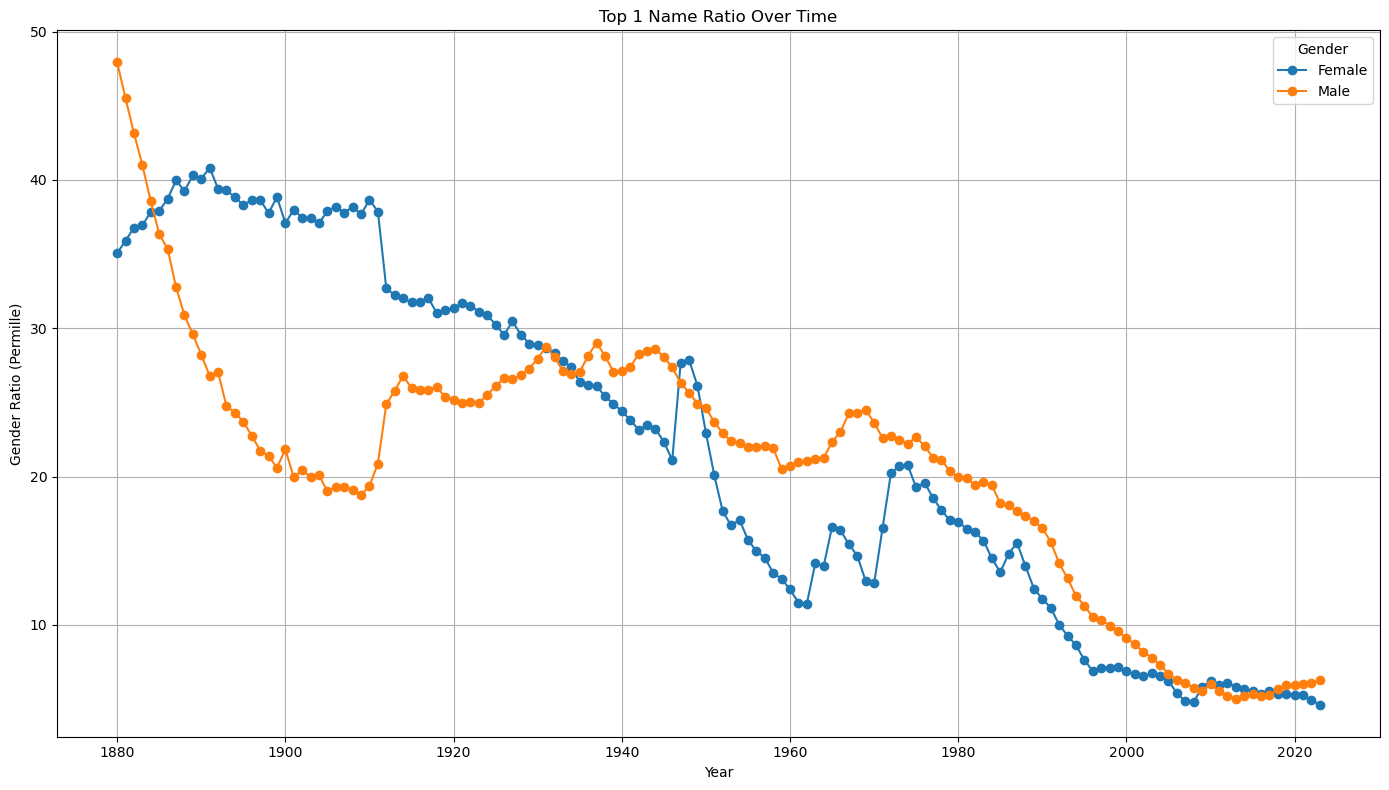

In [11]:
# Function to get the top 1 gender ratio for each year
def get_top_gender_ratio_per_year(data, gender):
    # Filter data for the specified gender
    gender_data = data[data['Gender'] == gender]

    # Group by Year and find the max Gender_Name_Ratio for each year
    top_gender_ratio_per_year = gender_data.loc[gender_data.groupby('Year')['Name_Ratio'].idxmax()].reset_index(drop=True)

    return top_gender_ratio_per_year

# Get the top 1 gender ratio per year for both female and male
top_female_gender_ratio_per_year = get_top_gender_ratio_per_year(data, 'F')
top_male_gender_ratio_per_year = get_top_gender_ratio_per_year(data, 'M')

# Plotting the results
plt.figure(figsize=(14, 8))

plt.plot(top_female_gender_ratio_per_year['Year'], top_female_gender_ratio_per_year['Name_Ratio'], marker='o', label='Female')
plt.plot(top_male_gender_ratio_per_year['Year'], top_male_gender_ratio_per_year['Name_Ratio'], marker='o', label='Male')

plt.title('Top 1 Name Ratio Over Time')
plt.xlabel('Year')
plt.ylabel('Gender Ratio (Permille)')
plt.legend(title='Gender')
plt.grid(True)
plt.tight_layout()
plt.show()

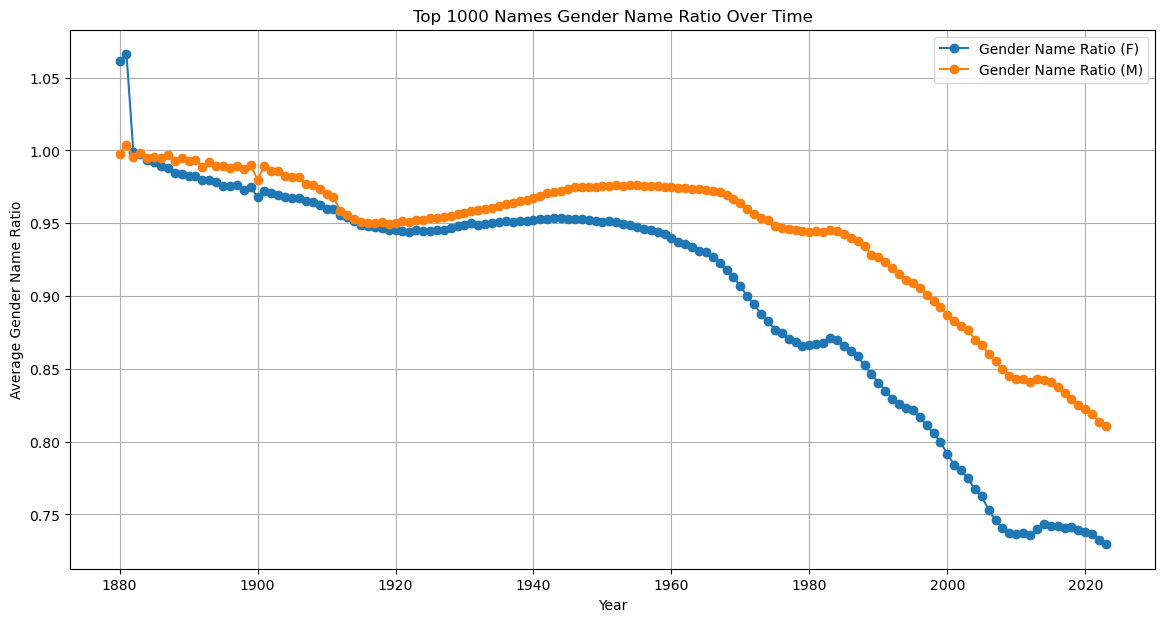

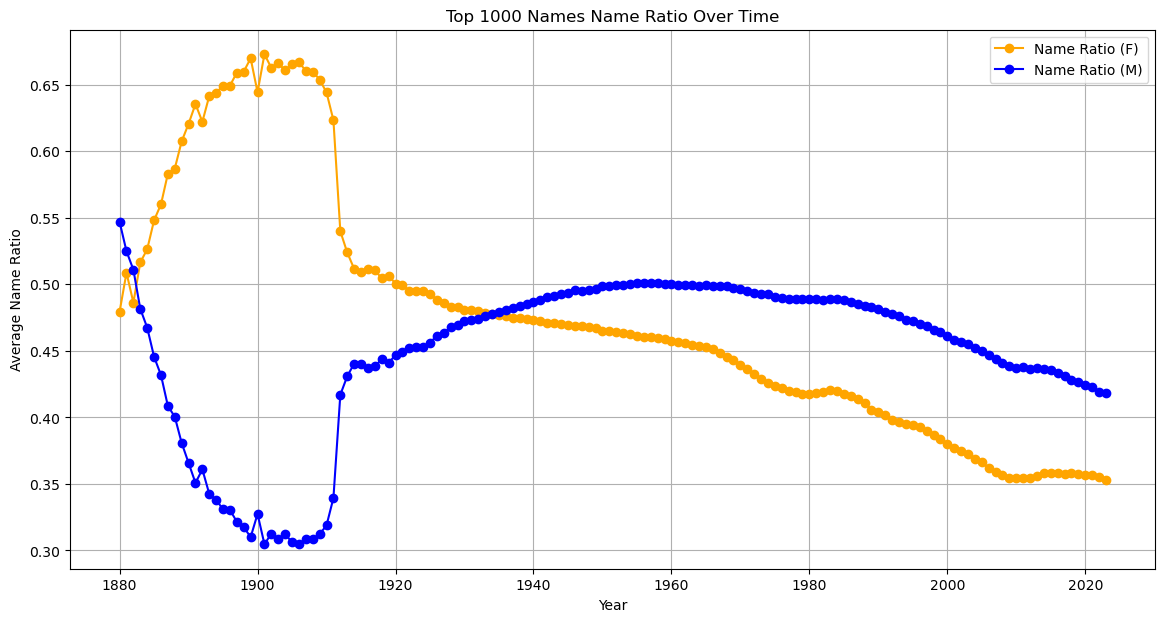

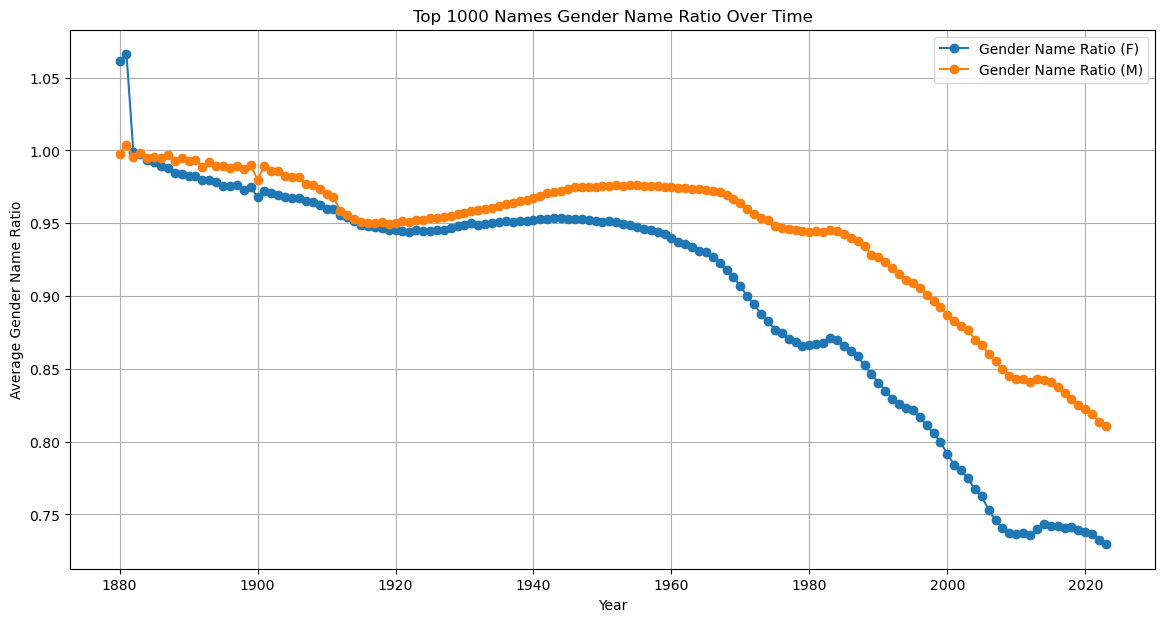

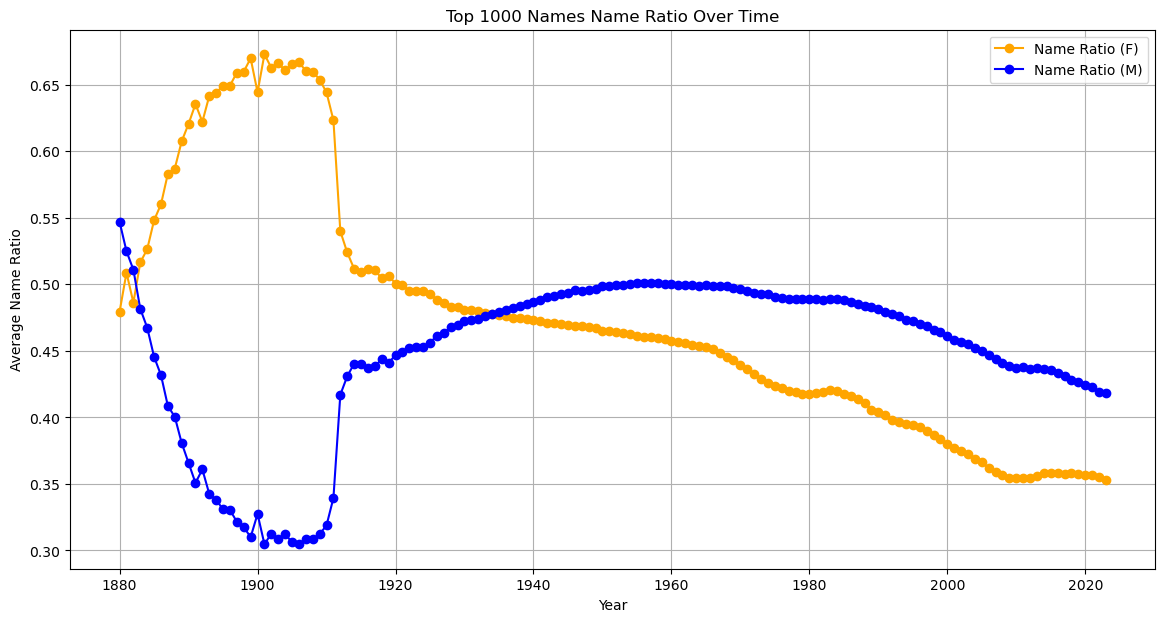

In [74]:
# Function to get the top 1000 names by count for each year and gender
def get_top_1000_names_per_year(data, gender):
    # Filter data for the specified gender
    gender_data = data[data['Gender'] == gender]
    
    # Initialize empty DataFrame to collect top 1000 names for each year
    top_1000_df = pd.DataFrame()
    
    # Iterate over each year to get the top 1000 names
    for year in gender_data['Year'].unique():
        year_data = gender_data[gender_data['Year'] == year]
        top_1000_year_data = year_data.nlargest(1000, 'Count')
        top_1000_df = pd.concat([top_1000_df, top_1000_year_data])
    
    return top_1000_df

# Function to plot metrics for both genders
def plot_top_1000_metrics(data):
    for gender in ['F', 'M']:
        top_1000_data = get_top_1000_names_per_year(data, gender)
        
        # Group by year and compute the average Gender_Name_Ratio and Name_Ratio
        grouped = top_1000_data.groupby('Year').agg({
            'Gender_Name_Ratio': 'mean',
            'Name_Ratio': 'mean'
        }).reset_index()
        
        # Plot Gender_Name_Ratio for both genders
        plt.figure(figsize=(14, 7))
        for g in ['F', 'M']:
            top_1000_data = get_top_1000_names_per_year(data, g)
            grouped = top_1000_data.groupby('Year').agg({
                'Gender_Name_Ratio': 'mean',
            }).reset_index()
            plt.plot(grouped['Year'], grouped['Gender_Name_Ratio'], marker='o', label=f'Gender Name Ratio ({g})')
        
        plt.title('Top 1000 Names Gender Name Ratio Over Time')
        plt.xlabel('Year')
        plt.ylabel('Average Gender Name Ratio')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Plot Name_Ratio for both genders
        plt.figure(figsize=(14, 7))
        for g in ['F', 'M']:
            top_1000_data = get_top_1000_names_per_year(data, g)
            grouped = top_1000_data.groupby('Year').agg({
                'Name_Ratio': 'mean',
            }).reset_index()
            plt.plot(grouped['Year'], grouped['Name_Ratio'], marker='o', label=f'Name Ratio ({g})', color='orange' if g == 'F' else 'blue')
        
        plt.title('Top 1000 Names Name Ratio Over Time')
        plt.xlabel('Year')
        plt.ylabel('Average Name Ratio')
        plt.legend()
        plt.grid(True)
        plt.show()

# Plot metrics for both Female and Male on the same plot
plot_top_1000_metrics(data)

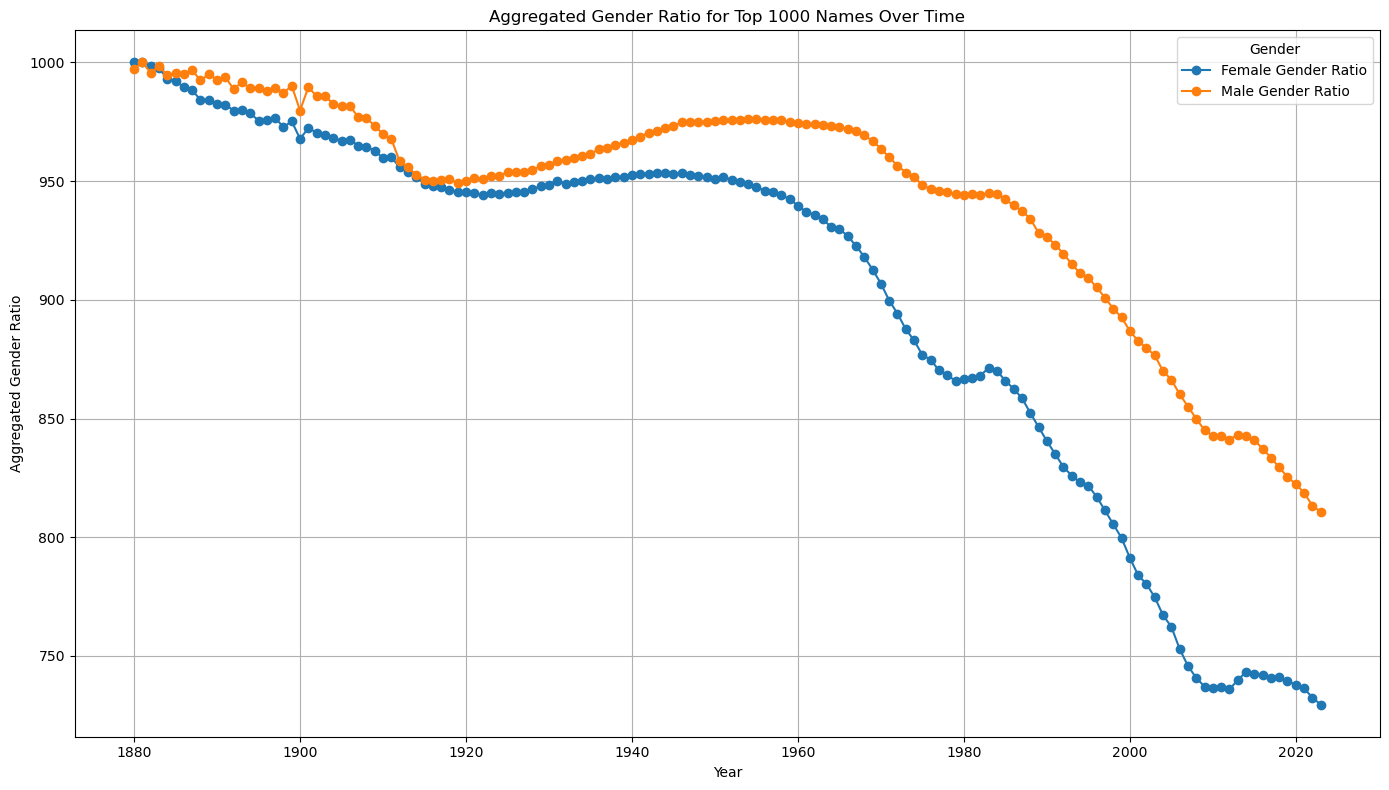

In [80]:
# Function to get top 1000 names per year and aggregate metrics
def get_top_1000_per_year_aggregation(data, gender):
    # Filter data for the specified gender
    gender_data = data[data['Gender'] == gender]
    
    # Initialize an empty DataFrame to collect results
    aggregated_data = pd.DataFrame()

    # Iterate over each year
    for year in gender_data['Year'].unique():
        year_data = gender_data[gender_data['Year'] == year]
        top_1000_names = year_data.nlargest(1000, 'Count')
        
        # Aggregate metrics for top 1000 names
        aggregated = top_1000_names.groupby('Year').agg({
            'Gender_Name_Ratio': 'sum',
            'Name_Ratio': 'sum'
        }).reset_index()

        aggregated_data = pd.concat([aggregated_data, aggregated], ignore_index=True)
    
    # Sort the data by Year
    aggregated_data = aggregated_data.sort_values(by='Year').reset_index(drop=True)
    
    return aggregated_data

# Get aggregated data for female and male
top_female_1000_aggregation = get_top_1000_per_year_aggregation(data, 'F')
top_male_1000_aggregation = get_top_1000_per_year_aggregation(data, 'M')

# Plotting the results
plt.figure(figsize=(14, 8))

plt.plot(top_female_1000_aggregation['Year'], top_female_1000_aggregation['Gender_Name_Ratio'], marker='o', label='Female Gender Ratio')
plt.plot(top_male_1000_aggregation['Year'], top_male_1000_aggregation['Gender_Name_Ratio'], marker='o', label='Male Gender Ratio')

plt.title('Aggregated Gender Ratio for Top 1000 Names Over Time')
plt.xlabel('Year')
plt.ylabel('Aggregated Gender Ratio')
plt.legend(title='Gender')
plt.grid(True)
plt.tight_layout()
plt.show()

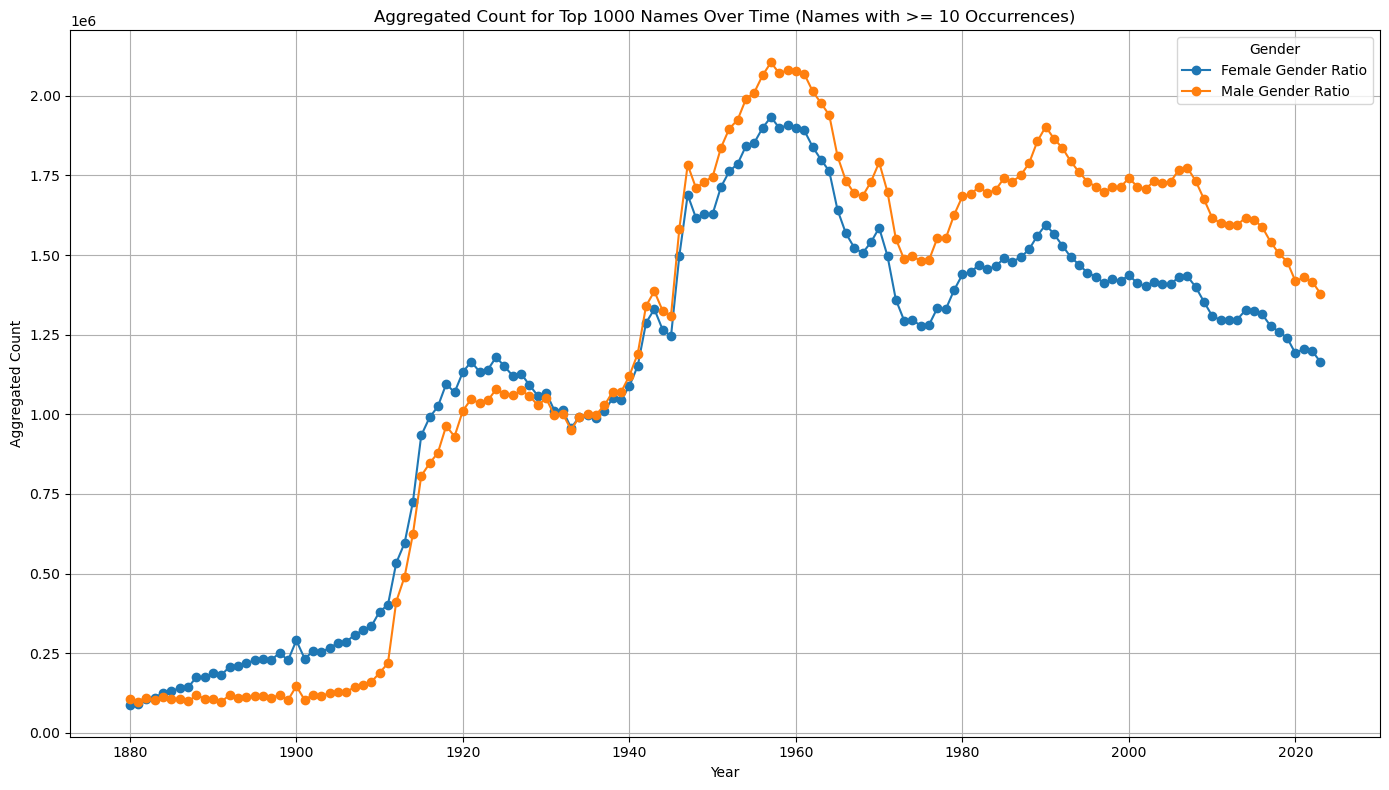

In [12]:
# Function to aggregate name gender ratio over years for top 1000 names and exclude names with fewer than 10 occurrences
def aggregate_name_gender_ratio(data, gender):
    # Filter data for the specified gender
    gender_data = data[data['Gender'] == gender]
    
    # Exclude names with fewer than 10 occurrences
    gender_data = gender_data[gender_data['Count'] >= 10]
    
    # Initialize an empty DataFrame to collect results
    aggregated_data = pd.DataFrame()
    
    # Iterate over each year
    for year in gender_data['Year'].unique():
        year_data = gender_data[gender_data['Year'] == year]
        top_1000_names = year_data.nlargest(1000, 'Count')
        
        # Aggregate metrics for top 1000 names
        aggregated = top_1000_names.groupby('Year').agg({
            'Count': 'sum',
            'Name_Ratio': 'sum'
        }).reset_index()

        aggregated_data = pd.concat([aggregated_data, aggregated], ignore_index=True)
    
    # Sort the data by Year
    aggregated_data = aggregated_data.sort_values(by='Year').reset_index(drop=True)
    
    return aggregated_data

# Get aggregated data for female and male
top_female_aggregation = aggregate_name_gender_ratio(data, 'F')
top_male_aggregation = aggregate_name_gender_ratio(data, 'M')

# Plotting the results for Gender Name Ratio
plt.figure(figsize=(14, 8))

plt.plot(top_female_aggregation['Year'], top_female_aggregation['Count'], marker='o', label='Female Gender Ratio')
plt.plot(top_male_aggregation['Year'], top_male_aggregation['Count'], marker='o', label='Male Gender Ratio')

plt.title('Aggregated Count for Top 1000 Names Over Time (Names with >= 10 Occurrences)')
plt.xlabel('Year')
plt.ylabel('Aggregated Count')
plt.legend(title='Gender')
plt.grid(True)
plt.tight_layout()
plt.show()

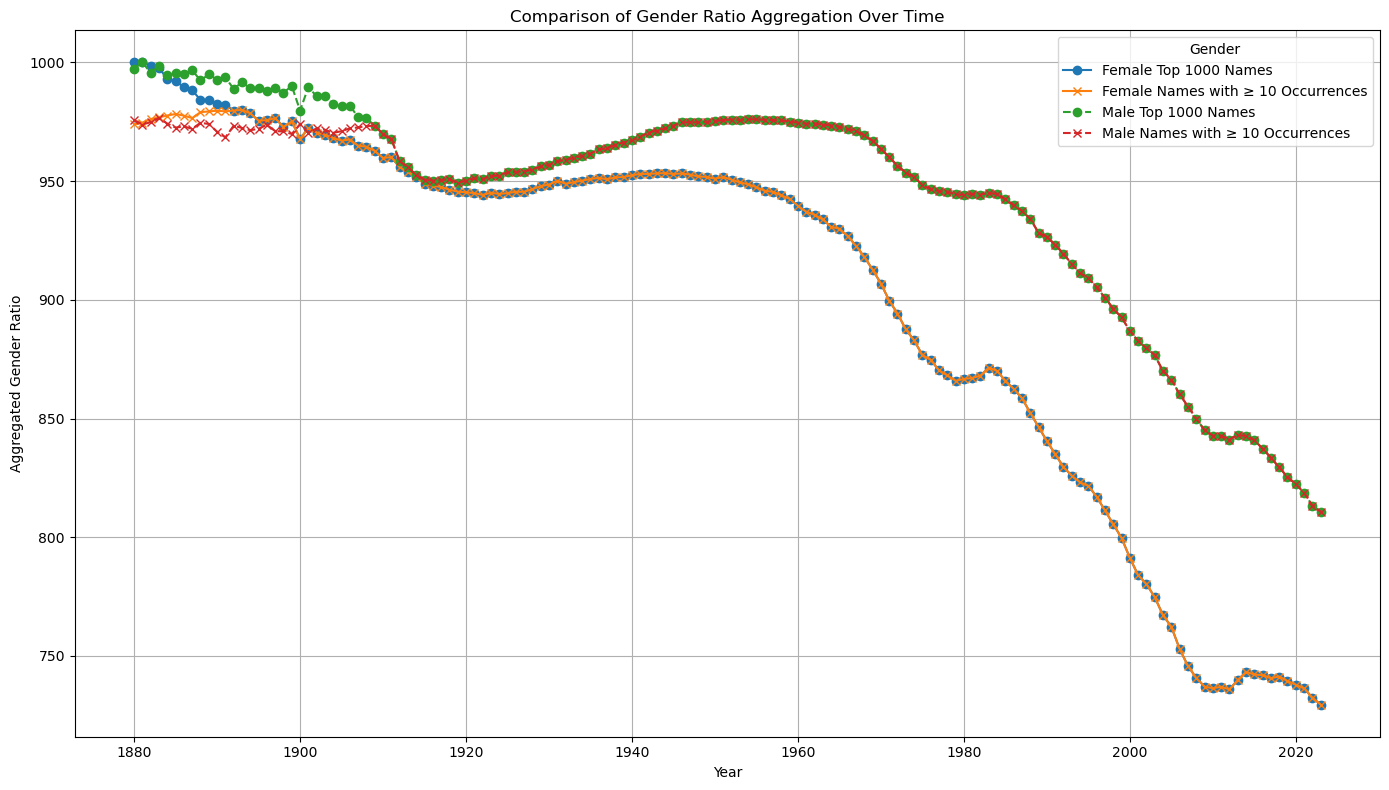

In [82]:
# Function to aggregate name gender ratio over years for top 1000 names
def aggregate_top_1000(data, gender):
    # Filter data for the specified gender
    gender_data = data[data['Gender'] == gender]
    
    # Initialize an empty DataFrame to collect results
    aggregated_data = pd.DataFrame()
    
    # Iterate over each year
    for year in gender_data['Year'].unique():
        year_data = gender_data[gender_data['Year'] == year]
        top_1000_names = year_data.nlargest(1000, 'Count')
        
        # Aggregate metrics for top 1000 names
        aggregated = top_1000_names.groupby('Year').agg({
            'Gender_Name_Ratio': 'sum',
            'Name_Ratio': 'sum'
        }).reset_index()

        aggregated_data = pd.concat([aggregated_data, aggregated], ignore_index=True)
    
    # Sort the data by Year
    aggregated_data = aggregated_data.sort_values(by='Year').reset_index(drop=True)
    
    return aggregated_data

# Function to aggregate name gender ratio over years excluding names with fewer than 10 occurrences
def aggregate_exclude_less_than_10(data, gender):
    # Filter data for the specified gender
    gender_data = data[data['Gender'] == gender]
    
    # Exclude names with fewer than 10 occurrences
    gender_data = gender_data[gender_data['Count'] >= 10]
    
    # Initialize an empty DataFrame to collect results
    aggregated_data = pd.DataFrame()
    
    # Iterate over each year
    for year in gender_data['Year'].unique():
        year_data = gender_data[gender_data['Year'] == year]
        top_1000_names = year_data.nlargest(1000, 'Count')
        
        # Aggregate metrics for top 1000 names
        aggregated = top_1000_names.groupby('Year').agg({
            'Gender_Name_Ratio': 'sum',
            'Name_Ratio': 'sum'
        }).reset_index()

        aggregated_data = pd.concat([aggregated_data, aggregated], ignore_index=True)
    
    # Sort the data by Year
    aggregated_data = aggregated_data.sort_values(by='Year').reset_index(drop=True)
    
    return aggregated_data

# Get aggregated data for female and male
top_female_1000 = aggregate_top_1000(data, 'F')
top_male_1000 = aggregate_top_1000(data, 'M')

filtered_female_10_or_more = aggregate_exclude_less_than_10(data, 'F')
filtered_male_10_or_more = aggregate_exclude_less_than_10(data, 'M')

# Plotting the results for Gender Name Ratio
plt.figure(figsize=(14, 8))

plt.plot(top_female_1000['Year'], top_female_1000['Gender_Name_Ratio'], marker='o', label='Female Top 1000 Names')
plt.plot(filtered_female_10_or_more['Year'], filtered_female_10_or_more['Gender_Name_Ratio'], marker='x', label='Female Names with ≥ 10 Occurrences')

plt.plot(top_male_1000['Year'], top_male_1000['Gender_Name_Ratio'], marker='o', linestyle='--', label='Male Top 1000 Names')
plt.plot(filtered_male_10_or_more['Year'], filtered_male_10_or_more['Gender_Name_Ratio'], marker='x', linestyle='--', label='Male Names with ≥ 10 Occurrences')

plt.title('Comparison of Gender Ratio Aggregation Over Time')
plt.xlabel('Year')
plt.ylabel('Aggregated Gender Ratio')
plt.legend(title='Gender')
plt.grid(True)
plt.tight_layout()
plt.show()

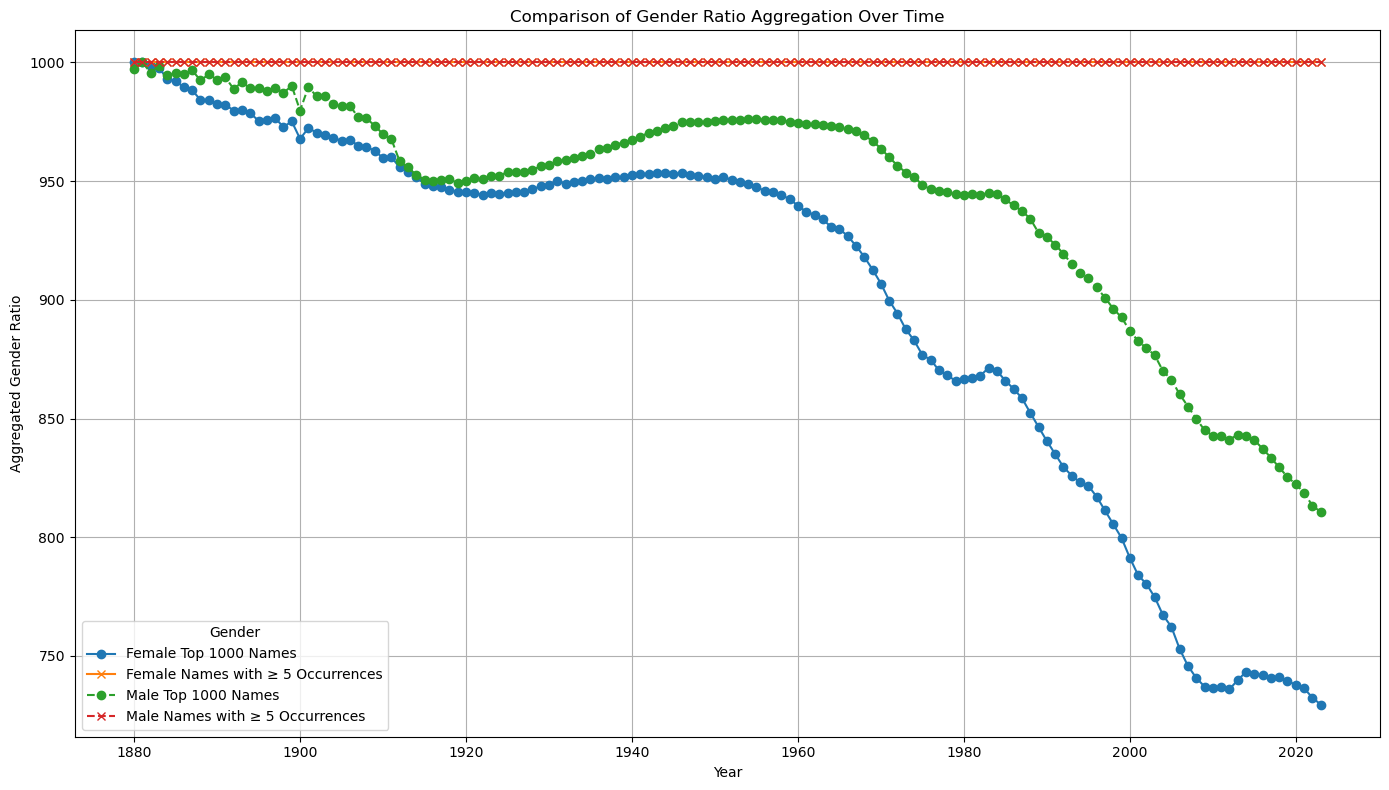

In [94]:
# Function to aggregate name gender ratio over years for top 1000 names
def aggregate_top_1000(data, gender):
    # Filter data for the specified gender
    gender_data = data[data['Gender'] == gender]
    
    # Initialize an empty DataFrame to collect results
    aggregated_data = pd.DataFrame()
    
    # Iterate over each year
    for year in gender_data['Year'].unique():
        year_data = gender_data[gender_data['Year'] == year]
        top_1000_names = year_data.nlargest(1000, 'Count')
        
        # Aggregate metrics for top 1000 names
        aggregated = top_1000_names.groupby('Year').agg({
            'Gender_Name_Ratio': 'sum'
        }).reset_index()

        aggregated_data = pd.concat([aggregated_data, aggregated], ignore_index=True)
    
    # Sort the data by Year
    aggregated_data = aggregated_data.sort_values(by='Year').reset_index(drop=True)
    
    return aggregated_data

# Function to aggregate name gender ratio over years for names with 5 or more occurrences
def aggregate_exclude_less_than_5(data, gender):
    # Filter data for the specified gender
    gender_data = data[data['Gender'] == gender]
    
    # Initialize an empty DataFrame to collect results
    aggregated_data = pd.DataFrame()
    
    # Iterate over each year
    for year in gender_data['Year'].unique():
        year_data = gender_data[gender_data['Year'] == year]
        
        # Exclude names with fewer than 5 occurrences
        filtered_data = year_data[year_data['Count'] >= 5]
        
        # Aggregate metrics for filtered names
        aggregated = filtered_data.groupby('Year').agg({
            'Gender_Name_Ratio': 'sum'
        }).reset_index()

        aggregated_data = pd.concat([aggregated_data, aggregated], ignore_index=True)
    
    # Sort the data by Year
    aggregated_data = aggregated_data.sort_values(by='Year').reset_index(drop=True)
    
    return aggregated_data

# Get aggregated data for female and male
top_female_1000 = aggregate_top_1000(data, 'F')
top_male_1000 = aggregate_top_1000(data, 'M')

filtered_female_5_or_more = aggregate_exclude_less_than_5(data, 'F')
filtered_male_5_or_more = aggregate_exclude_less_than_5(data, 'M')

# Plotting the results for Gender Name Ratio
plt.figure(figsize=(14, 8))

plt.plot(top_female_1000['Year'], top_female_1000['Gender_Name_Ratio'], marker='o', label='Female Top 1000 Names')
plt.plot(filtered_female_5_or_more['Year'], filtered_female_5_or_more['Gender_Name_Ratio'], marker='x', label='Female Names with ≥ 5 Occurrences')

plt.plot(top_male_1000['Year'], top_male_1000['Gender_Name_Ratio'], marker='o', linestyle='--', label='Male Top 1000 Names')
plt.plot(filtered_male_5_or_more['Year'], filtered_male_5_or_more['Gender_Name_Ratio'], marker='x', linestyle='--', label='Male Names with ≥ 5 Occurrences')

plt.title('Comparison of Gender Ratio Aggregation Over Time')
plt.xlabel('Year')
plt.ylabel('Aggregated Gender Ratio')
plt.legend(title='Gender')
plt.grid(True)
plt.tight_layout()
plt.show()

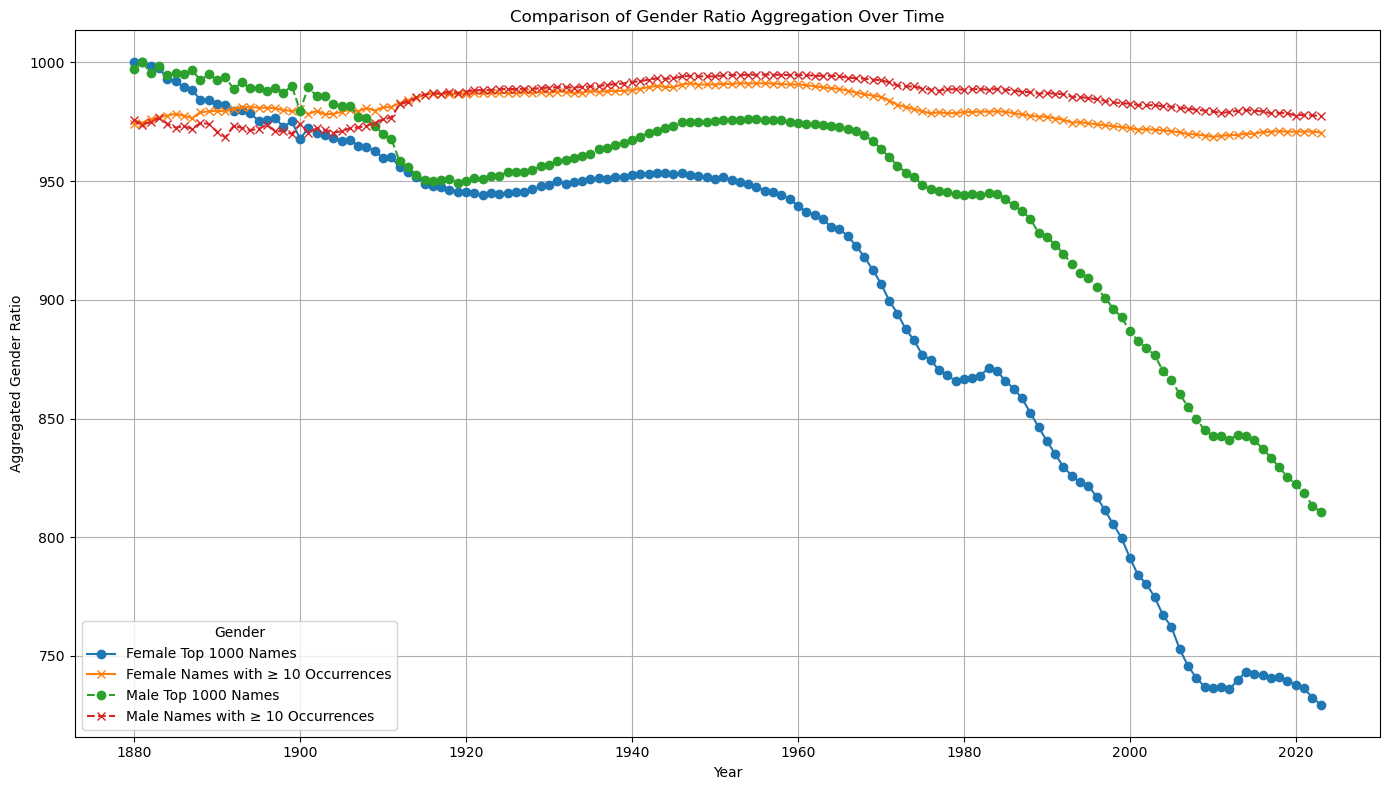

In [93]:
# Function to aggregate name gender ratio over years for top 1000 names
def aggregate_top_1000(data, gender):
    # Filter data for the specified gender
    gender_data = data[data['Gender'] == gender]
    
    # Initialize an empty DataFrame to collect results
    aggregated_data = pd.DataFrame()
    
    # Iterate over each year
    for year in gender_data['Year'].unique():
        year_data = gender_data[gender_data['Year'] == year]
        top_1000_names = year_data.nlargest(1000, 'Count')
        
        # Aggregate metrics for top 1000 names
        aggregated = top_1000_names.groupby('Year').agg({
            'Gender_Name_Ratio': 'sum'
        }).reset_index()

        aggregated_data = pd.concat([aggregated_data, aggregated], ignore_index=True)
    
    # Sort the data by Year
    aggregated_data = aggregated_data.sort_values(by='Year').reset_index(drop=True)
    
    return aggregated_data

# Function to aggregate name gender ratio over years for names with 10 or more occurrences
def aggregate_exclude_less_than_10(data, gender):
    # Filter data for the specified gender
    gender_data = data[data['Gender'] == gender]
    
    # Initialize an empty DataFrame to collect results
    aggregated_data = pd.DataFrame()
    
    # Iterate over each year
    for year in gender_data['Year'].unique():
        year_data = gender_data[gender_data['Year'] == year]
        
        # Exclude names with fewer than 10 occurrences
        filtered_data = year_data[year_data['Count'] >= 10]
        
        # Aggregate metrics for filtered names
        aggregated = filtered_data.groupby('Year').agg({
            'Gender_Name_Ratio': 'sum'
        }).reset_index()

        aggregated_data = pd.concat([aggregated_data, aggregated], ignore_index=True)
    
    # Sort the data by Year
    aggregated_data = aggregated_data.sort_values(by='Year').reset_index(drop=True)
    
    return aggregated_data

# Get aggregated data for female and male
top_female_1000 = aggregate_top_1000(data, 'F')
top_male_1000 = aggregate_top_1000(data, 'M')

filtered_female_10_or_more = aggregate_exclude_less_than_10(data, 'F')
filtered_male_10_or_more = aggregate_exclude_less_than_10(data, 'M')

# Plotting the results for Gender Name Ratio
plt.figure(figsize=(14, 8))

plt.plot(top_female_1000['Year'], top_female_1000['Gender_Name_Ratio'], marker='o', label='Female Top 1000 Names')
plt.plot(filtered_female_10_or_more['Year'], filtered_female_10_or_more['Gender_Name_Ratio'], marker='x', label='Female Names with ≥ 10 Occurrences')

plt.plot(top_male_1000['Year'], top_male_1000['Gender_Name_Ratio'], marker='o', linestyle='--', label='Male Top 1000 Names')
plt.plot(filtered_male_10_or_more['Year'], filtered_male_10_or_more['Gender_Name_Ratio'], marker='x', linestyle='--', label='Male Names with ≥ 10 Occurrences')

plt.title('Comparison of Gender Ratio Aggregation Over Time')
plt.xlabel('Year')
plt.ylabel('Aggregated Gender Ratio')
plt.legend(title='Gender')
plt.grid(True)
plt.tight_layout()
plt.show()

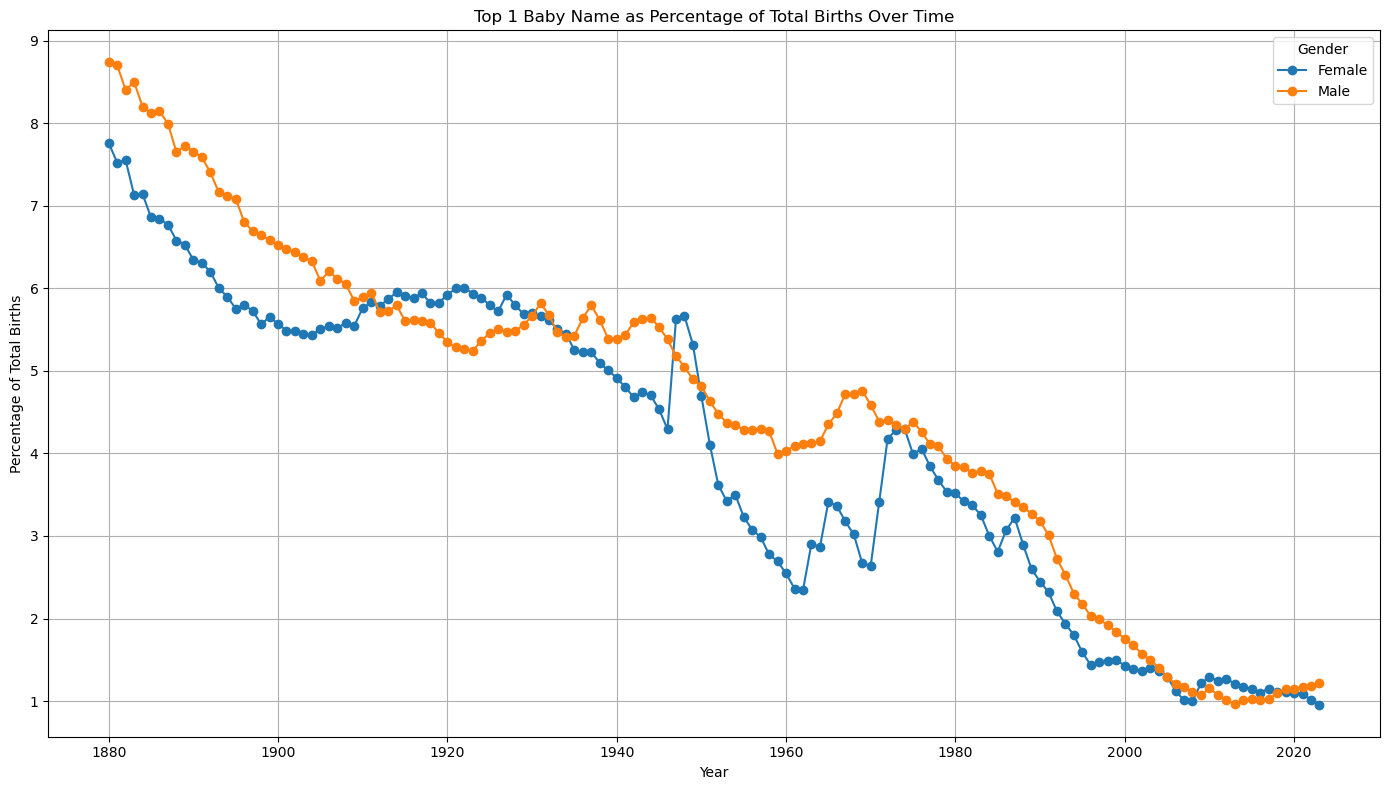

In [87]:
# Function to calculate the top 1 name's percentage of total births per year
def top_name_percentage(data, gender):
    # Filter data for the specified gender
    gender_data = data[data['Gender'] == gender]
    
    # Calculate total births per year
    total_births_per_year = gender_data.groupby('Year')['Count'].sum().reset_index()
    total_births_per_year.columns = ['Year', 'Total_Count']
    
    # Find the top 1 name per year
    top_names_per_year = gender_data.loc[gender_data.groupby('Year')['Count'].idxmax()].reset_index(drop=True)
    
    # Merge with total births to calculate percentage
    merged_data = pd.merge(top_names_per_year, total_births_per_year, on='Year')
    merged_data['Percentage'] = (merged_data['Count'] / merged_data['Total_Count']) * 100
    
    return merged_data

# Get the top name percentage for female and male
top_female_percentage = top_name_percentage(data, 'F')
top_male_percentage = top_name_percentage(data, 'M')

# Ensure all years are included in the plot, even if the top name count is zero
years_range = pd.DataFrame({'Year': range(data['Year'].min(), data['Year'].max() + 1)})
top_female_percentage = pd.merge(years_range, top_female_percentage, on='Year', how='left').fillna(0)
top_male_percentage = pd.merge(years_range, top_male_percentage, on='Year', how='left').fillna(0)

# Plotting the results
plt.figure(figsize=(14, 8))

plt.plot(top_female_percentage['Year'], top_female_percentage['Percentage'], marker='o', label='Female')
plt.plot(top_male_percentage['Year'], top_male_percentage['Percentage'], marker='o', label='Male')

plt.title('Top 1 Baby Name as Percentage of Total Births Over Time')
plt.xlabel('Year')
plt.ylabel('Percentage of Total Births')
plt.legend(title='Gender')
plt.grid(True)
plt.tight_layout()
plt.show()

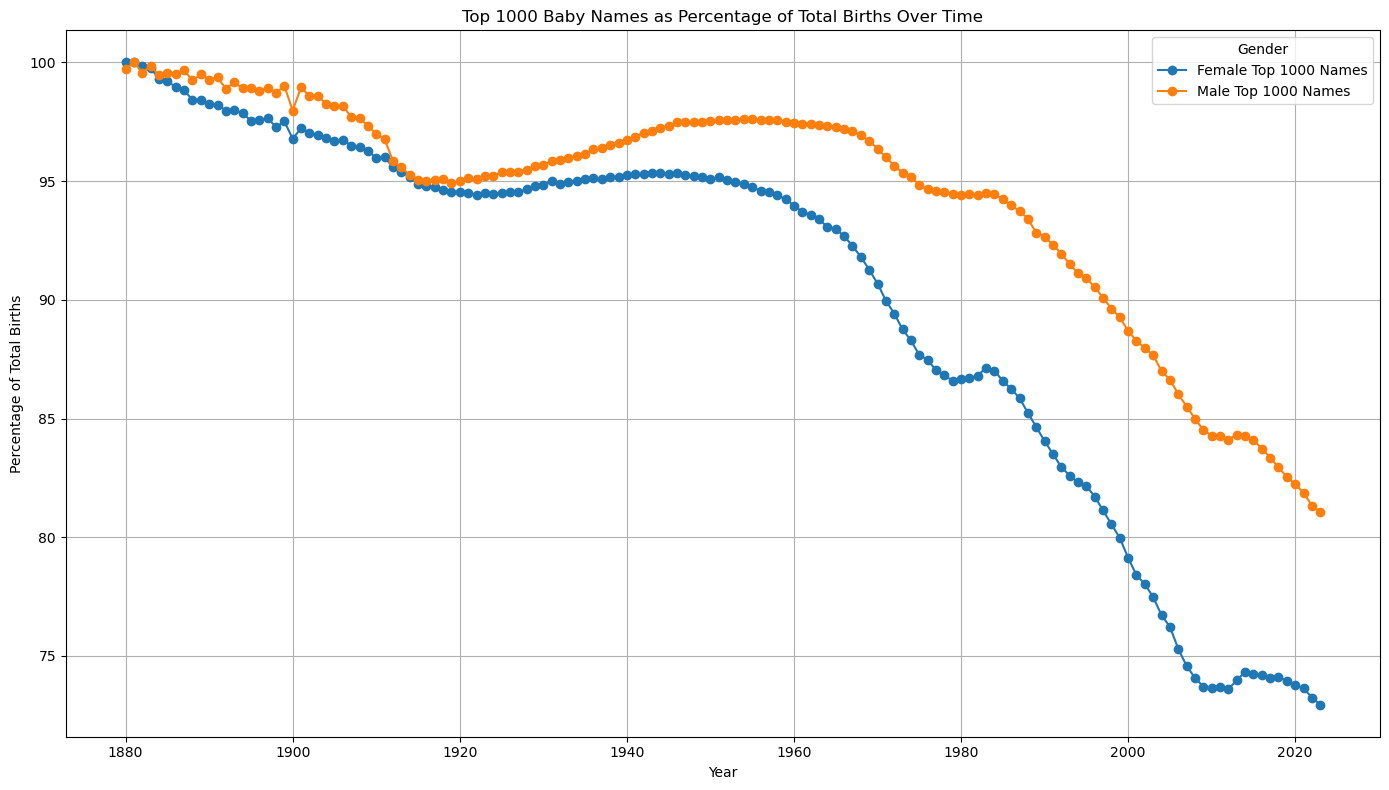

In [89]:
# Function to calculate the top 1000 names' percentage of total births per year
def top_1000_percentage(data, gender):
    # Filter data for the specified gender
    gender_data = data[data['Gender'] == gender]
    
    # Calculate total births per year
    total_births_per_year = gender_data.groupby('Year')['Count'].sum().reset_index()
    total_births_per_year.columns = ['Year', 'Total_Count']
    
    # Initialize a list to collect results
    results = []
    
    # Iterate over each year to compute the percentage of top 1000 names
    for year in sorted(gender_data['Year'].unique()):
        year_data = gender_data[gender_data['Year'] == year]
        
        # Get the top 1000 names by count for that year
        top_1000_names = year_data.nlargest(1000, 'Count')
        
        # Calculate the sum of counts for these top 1000 names
        top_1000_total_count = top_1000_names['Count'].sum()
        
        # Find the total number of births for that year
        total_count = total_births_per_year[total_births_per_year['Year'] == year]['Total_Count'].values[0]
        
        # Calculate the percentage
        percentage = (top_1000_total_count / total_count) * 100
        
        # Append to the results list
        results.append({'Year': year, 'Percentage': percentage})
    
    # Convert the results list to a DataFrame
    top_1000_percentage_data = pd.DataFrame(results)
    
    return top_1000_percentage_data

# Get the top 1000 names percentage for female and male
top_female_1000_percentage = top_1000_percentage(data, 'F')
top_male_1000_percentage = top_1000_percentage(data, 'M')

# Ensure all years are included in the plot
years_range = pd.DataFrame({'Year': range(data['Year'].min(), data['Year'].max() + 1)})
top_female_1000_percentage = pd.merge(years_range, top_female_1000_percentage, on='Year', how='left').fillna(0)
top_male_1000_percentage = pd.merge(years_range, top_male_1000_percentage, on='Year', how='left').fillna(0)

# Plotting the results
plt.figure(figsize=(14, 8))

plt.plot(top_female_1000_percentage['Year'], top_female_1000_percentage['Percentage'], marker='o', label='Female Top 1000 Names')
plt.plot(top_male_1000_percentage['Year'], top_male_1000_percentage['Percentage'], marker='o', label='Male Top 1000 Names')

plt.title('Top 1000 Baby Names as Percentage of Total Births Over Time')
plt.xlabel('Year')
plt.ylabel('Percentage of Total Births')
plt.legend(title='Gender')
plt.grid(True)
plt.tight_layout()
plt.show()

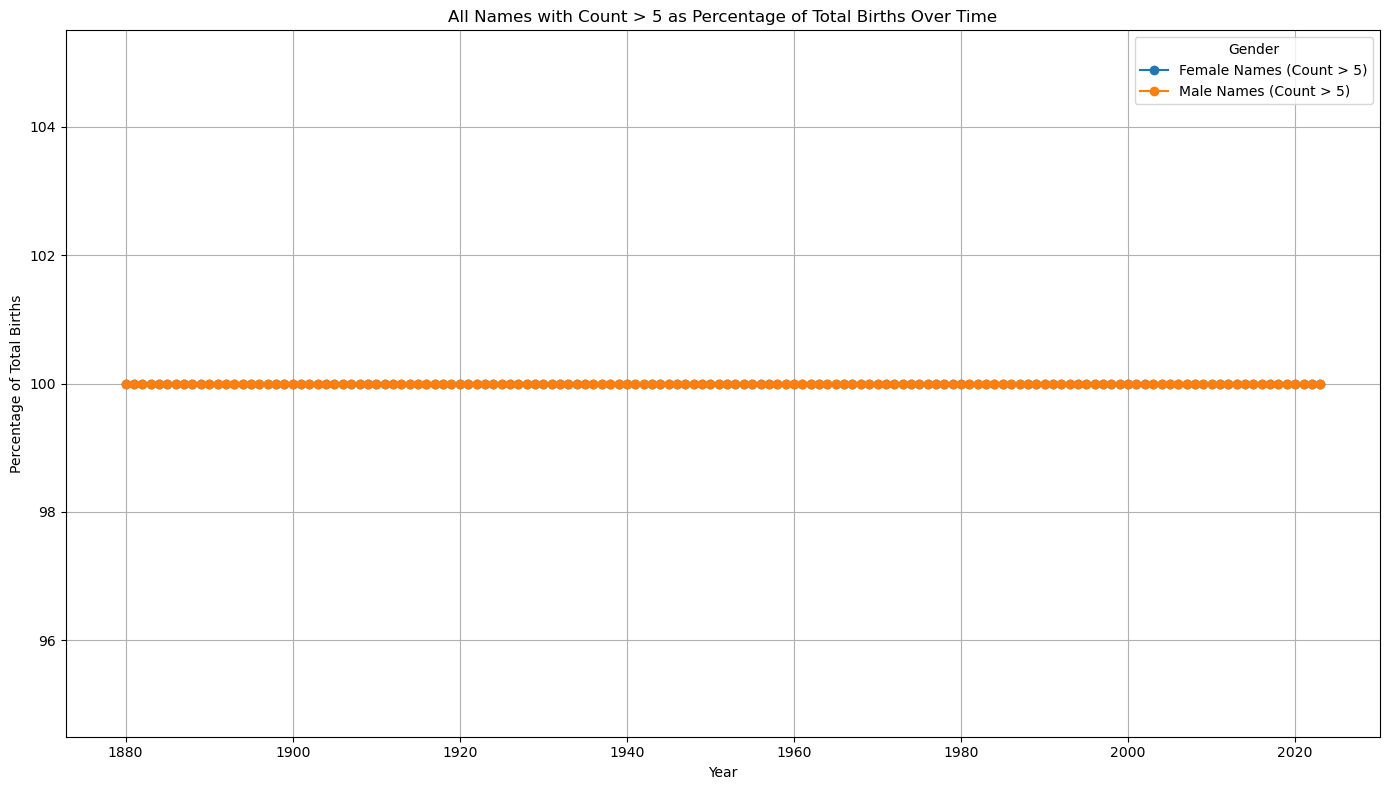

In [90]:
# Function to calculate the aggregated percentage of total births for names with more than 5 occurrences
def name_percentage_min_occurrences(data, gender, min_occurrences=6):
    # Filter data for the specified gender and names with more than min_occurrences
    gender_data = data[(data['Gender'] == gender) & (data['Count'] >= min_occurrences)]
    
    # Calculate total births per year
    total_births_per_year = gender_data.groupby('Year')['Count'].sum().reset_index()
    total_births_per_year.columns = ['Year', 'Total_Count']
    
    # Initialize a list to collect results
    results = []
    
    # Iterate over each year to compute the percentage
    for year in sorted(gender_data['Year'].unique()):
        year_data = gender_data[gender_data['Year'] == year]
        
        # Calculate the sum of counts for names with more than min_occurrences
        total_filtered_count = year_data['Count'].sum()
        
        # Find the total number of births for that year
        total_count = total_births_per_year[total_births_per_year['Year'] == year]['Total_Count'].values[0]
        
        # Calculate the percentage
        percentage = (total_filtered_count / total_count) * 100
        
        # Append to the results list
        results.append({'Year': year, 'Percentage': percentage})
    
    # Convert the results list to a DataFrame
    percentage_data = pd.DataFrame(results)
    
    return percentage_data

# Get the percentage for names with more than 5 occurrences for female and male
filtered_female_percentage = name_percentage_min_occurrences(data, 'F')
filtered_male_percentage = name_percentage_min_occurrences(data, 'M')

# Ensure all years are included in the plot
years_range = pd.DataFrame({'Year': range(data['Year'].min(), data['Year'].max() + 1)})
filtered_female_percentage = pd.merge(years_range, filtered_female_percentage, on='Year', how='left').fillna(0)
filtered_male_percentage = pd.merge(years_range, filtered_male_percentage, on='Year', how='left').fillna(0)

# Plotting the results
plt.figure(figsize=(14, 8))

plt.plot(filtered_female_percentage['Year'], filtered_female_percentage['Percentage'], marker='o', label='Female Names (Count > 5)')
plt.plot(filtered_male_percentage['Year'], filtered_male_percentage['Percentage'], marker='o', label='Male Names (Count > 5)')

plt.title('All Names with Count > 5 as Percentage of Total Births Over Time')
plt.xlabel('Year')
plt.ylabel('Percentage of Total Births')
plt.legend(title='Gender')
plt.grid(True)
plt.tight_layout()
plt.show()